In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
from Models.SATNet_E import SATNet_E
from datetime import datetime
from utils.tools import make_datasets,make_dir
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

# 数据加载
data_Dir = "/home/admin123/SATData/data"
# 实例化数据集
emg_data, angle_data = make_datasets(data_Dir, peopleList=['S01'], exp_class="MJ", cluster_num=6, fusionMethod="PCA", windowLength=256, stepLength=1, delta_T=20)

semgData = torch.tensor(emg_data, dtype=torch.float32)
angleData = torch.tensor(angle_data, dtype=torch.float32)
print("semg 数据形状为：", semgData.shape)
print("angle 数据形状为：", angleData.shape)

dataset = TensorDataset(semgData, angleData)

# 定义划分比例
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
# 数据集分割
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 数据加载
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 初始化模型、优化器和损失函数
modelName = "SAT-E"
model = SATNet_E(PreNum=3)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
criterion = criterion.cuda()
# scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=0)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

formatted_time = datetime.now().strftime("%m-%d-%H:%M:%S")
checkpoint_save_Dir = os.path.join("/home/admin123/SATData", "Run", modelName, formatted_time)
make_dir(checkpoint_save_Dir)
checkpoint_save_path = os.path.join(checkpoint_save_Dir,"best.pth")

best_loss = float('inf')
train_running_loss_ls = []
test_running_loss_ls = []
for epoch in range(1, 2001):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("learning rate=", optimizer.param_groups[0]['lr'])
    scheduler.step()
    train_running_loss_ls.append(running_loss)
    
    # 测试模型
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_running_loss_ls.append(test_loss)

    # if epoch % 50 == 0:

    print('Epoch %d, Train Loss: %.5f, Test Loss: %.5f'%(epoch, running_loss, test_loss*train_size/test_size))

    if running_loss < best_loss:
        best_loss = running_loss
        torch.save(model.state_dict(), checkpoint_save_path)
        # print("model update")s

loss 文件已保存到: /home/admin123/SATData/Run/SAT/04-13-17:24:33/output.csv


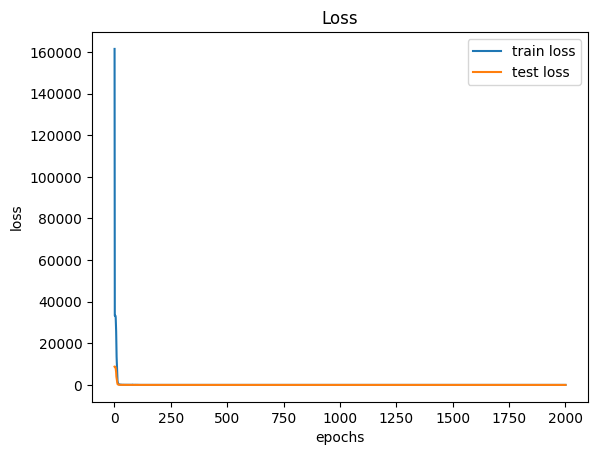

In [ ]:
import csv
# 计算性能指标
import matplotlib.pyplot as plt
from Models.SATNet import SATNet
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

file_path = os.path.join(checkpoint_save_Dir, "output.csv")
# 将两个列表写入到 CSV 文件
with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    
    # 写入表头（可选）
    writer.writerow(["train_loss", "test_loss"])
    
    # 写入数据
    for item1, item2 in zip(train_running_loss_ls, test_running_loss_ls):
        writer.writerow([item1, item2])
print(f"loss 文件已保存到: {file_path}")

# 绘制 loss 曲线
plt.figure()
plt.plot(np.arange(len(train_running_loss_ls))+1, train_running_loss_ls, label="train loss")
plt.plot(np.arange(len(test_running_loss_ls))+1, test_running_loss_ls, label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()
plt.savefig(os.path.join(checkpoint_save_Dir, "loss.png"), dpi=300, bbox_inches='tight')


NameError: name 'mean_squared_error' is not defined

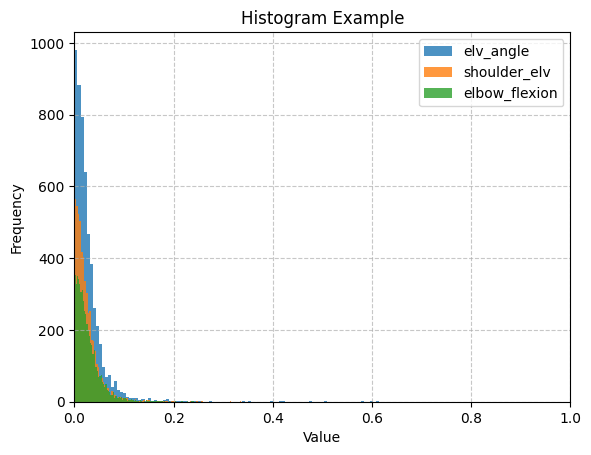

In [5]:
import matplotlib.pyplot as plt
# 初始化模型结构
model_eval = SATNet().cuda()
# model_eval.load_state_dict(torch.load(checkpoint_save_path))

model_eval = model
model_eval.eval()
truthAnglesList = []
preAnglesList = []
for inputs, labels in test_loader:
    truthAnglesList.append(labels)
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model_eval(inputs)
    preAnglesList.append(outputs.cpu().detach().numpy())

truthAngles = np.concatenate(truthAnglesList, axis=0)
preAngles = np.concatenate(preAnglesList, axis=0)

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure()
plt.hist(np.abs(tru_angle_1-pre_angle_1), bins=100, alpha=0.8, label="elv_angle")
plt.hist(np.abs(tru_angle_2-pre_angle_2), bins=100, alpha=0.8, label="shoulder_elv")
plt.hist(np.abs(tru_angle_3-pre_angle_3), bins=100, alpha=0.8, label="elbow_flexion")
plt.xlim((0, 1))
plt.legend()
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(checkpoint_save_Dir, "test_error.png"), dpi=300, bbox_inches='tight')

rmse, mae, r2 = [], [], []
rmse.append(np.sqrt(mean_squared_error(tru_angle_1, pre_angle_1)))
rmse.append(np.sqrt(mean_squared_error(tru_angle_2, pre_angle_2)))
rmse.append(np.sqrt(mean_squared_error(tru_angle_3, pre_angle_3)))

mae.append(mean_absolute_error(tru_angle_1, pre_angle_1))
mae.append(mean_absolute_error(tru_angle_2, pre_angle_2))
mae.append(mean_absolute_error(tru_angle_2, pre_angle_2))

r2.append(r2_score(tru_angle_1, pre_angle_1))
r2.append(r2_score(tru_angle_2, pre_angle_2))
r2.append(r2_score(tru_angle_2, pre_angle_2))

file_path = os.path.join(checkpoint_save_Dir, "metrics.csv")
# 将两个列表写入到 CSV 文件
with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    
    # 写入表头（可选）
    writer.writerow(["rmse", "mae", "R2_score"])
    
    # 写入数据
    for item1, item2, item3 in zip(rmse, mae, r2):
        writer.writerow([item1, item2, item3])
print(f"metrics 文件已保存到: {file_path}")



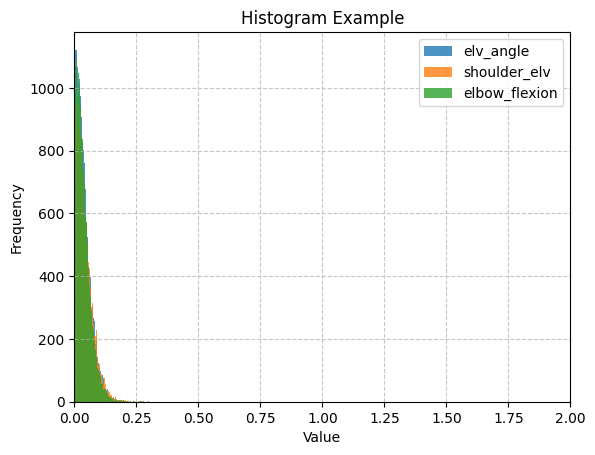

In [ ]:
model_eval.eval()
truthAnglesList = []
preAnglesList = []
for inputs, labels in train_loader:
    truthAnglesList.append(labels)
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = model_eval(inputs)
    preAnglesList.append(outputs.cpu().detach().numpy())

truthAngles = np.concatenate(truthAnglesList, axis=0)
preAngles = np.concatenate(preAnglesList, axis=0)

tru_angle_1 = truthAngles[:,0].T
tru_angle_2 = truthAngles[:,1].T
tru_angle_3 = truthAngles[:,2].T

pre_angle_1 = preAngles[:,0].T
pre_angle_2 = preAngles[:,1].T
pre_angle_3 = preAngles[:,2].T

plt.figure()
plt.hist(np.abs(tru_angle_1-pre_angle_1), bins=100, alpha=0.8, label="elv_angle")
plt.hist(np.abs(tru_angle_2-pre_angle_2), bins=100, alpha=0.8, label="shoulder_elv")
plt.hist(np.abs(tru_angle_3-pre_angle_3), bins=100, alpha=0.8, label="elbow_flexion")
plt.xlim((0, 2))
plt.legend()
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(checkpoint_save_Dir, "train_error.png"), dpi=300, bbox_inches='tight')